# NIRCam subarray -- smooth1overf Willott

Analyzing JWST NIRCam calibration data of a standard star observed in various subarrays to ensure photometry is robust.

JWST CAL 4452  
https://www.stsci.edu/jwst/science-execution/program-information?id=4452  
https://www.stsci.edu/cgi-bin/get-visit-status?observatory=JWST&id=4452  


All imaging but including subarrays defined for other modes:  
 1 - 36: imaging  
37 – 46: grism  
47 – 56: coronagraphy  
https://docs.google.com/spreadsheets/d/1OV8J8RZ0hMWo-u0saz6Wjs_RH9lqB7D4m0Pcbk00AXI




In [1]:
import numpy as np
import os
from glob import glob
from copy import deepcopy
home = os.path.expanduser("~")
import warnings  # to suppress warnings from photutils

In [2]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import ticker
from matplotlib.ticker import ScalarFormatter, FuncFormatter, MultipleLocator
%matplotlib inline
plt.style.use('https://www.stsci.edu/~dcoe/matplotlibrc.txt') # https://matplotlib.org/tutorials/introductory/customizing.html
mpl_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
import astropy
import astropy.io
from astropy.io import fits
import astropy.io.ascii
import astropy.wcs as wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm, SqrtStretch, LogStretch, hist, LinearStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from astropy.visualization import make_lupton_rgb
from astropy.stats import SigmaClip, sigma_clipped_stats
from astropy.convolution import convolve, Gaussian2DKernel, interpolate_replace_nans

In [4]:
import photutils
print('photutils', photutils.__version__)
from photutils.aperture import SkyCircularAperture, CircularAperture, CircularAnnulus, ApertureStats  # https://photutils.readthedocs.io/en/stable/aperture.html
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_sources, SourceCatalog

photutils 1.9.0


In [6]:
import fnmatch

def select_jwst_files(filename_list, program='?????', observation='???', visit='???', group='??', prime_parallel='?', activity='??', 
                      exposure='?????', detector='*', filetype='*', extension='fits'):
    #if type(observation) in (int, float):
    #filename_list = [os.path.basename(infile) for infile in filename_list]
    observation = '%03d' % observation
    search_string = 'jw' + program + observation + visit \
        + '_' + group + prime_parallel + activity + '_' + exposure \
        + '_' + detector + '_' + filetype + '.' + extension

    return fnmatch.filter(filename_list, search_string)

In [7]:
datadir = 'images'
allfiles = glob(os.path.join(datadir, '*'))
allfiles = [os.path.basename(infile) for infile in allfiles]
allfiles = np.sort(allfiles).tolist()
#allfiles

In [8]:
infiles = select_jwst_files(allfiles, observation=9, filetype='cal')
num_exposures = len(infiles)
infiles

['jw04452009001_02102_00001_nrcb1_cal.fits',
 'jw04452009001_02102_00002_nrcb1_cal.fits',
 'jw04452009001_02102_00003_nrcb1_cal.fits',
 'jw04452009001_02102_00004_nrcb1_cal.fits']

# 1/f noise removal

### Chris Willott: image1overf

https://github.com/chriswillott/jwst

In [11]:
#from image1overf import sub1fimaging
#from image1overf_withbkgd_quadbyquad import sub1fimaging  # Bryan Hilbert's tweak: measure background in individual amplifiers

In [28]:
from image1overf_subarrays import sub1fimaging

In [32]:
import image1overf_subarrays
from importlib import reload
reload(image1overf_subarrays)

<module 'image1overf_subarrays' from '/Users/dcoe/NIRCam/flux/notebooks/image1overf_subarrays.py'>

In [29]:
image_file = infiles[0]
input_file = os.path.join(datadir, image_file)
input_file

'images/jw04452009001_02102_00001_nrcb1_cal.fits'

In [30]:
# Corrected files will be saved in output directory, by default named "calibrated"
output_dir = 'corrected/image1overf'
os.makedirs(output_dir, exist_ok=True)  # for output files
output_dir

'corrected/image1overf'

In [33]:
with fits.open(input_file) as cal2hdulist:
    corrected_cal2hdulist = image1overf_subarrays.sub1fimaging(cal2hdulist, sigma_bgmask=3.0, sigma_1fmask=2.0, splitamps=True, usesegmask=True)
    output_file = image_file.replace('_cal.fits','_cal_1overf.fits')
    output_file = os.path.join(output_dir, output_file)
    cal2hdulist.writeto(output_file, overwrite=True)

# Options:
# sigma_bgmask - sigma of outliers for masking when making background  (suggested value=3.0)
# sigma_1fmask - sigma of outliers for masking when making 1/f correction  (suggested value=2.0)
# splitamps - fit each of the 4 amps separately when full-frame  (set this to True when the field is sparse)
# usesegmask - whether to use a segmentation image as the mask before fitting 1/f stripes (recommend set to True in most cases)

In [42]:
import matplotlib.pyplot as plt

def display_images_norm(image_data, corrected_data, corrected_title, filename, xsize=12, ysize=12, aspect=1, cmap='viridis',
                  save_plot=None, dpi=150):
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)
    plt.rc('axes',  labelsize=10)
    plt.rc('axes',  titlesize=12)
    
    fig, axs = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True, layout='compressed')
    axs = axs.flatten()
    
    plot_data = image_data, corrected_data
    
    for i in range(2):
        data = plot_data[i]
        data = np.nan_to_num(data)  # replace nan with zero
        #im = axs[i].imshow(data, vmin=vmin, vmax=vmax, origin='lower')
        norm = simple_norm(data, 'sqrt', percent=99.9)
        im = axs[i].imshow(data, norm=norm, origin='lower', interpolation='nearest', cmap=cmap)
    
    axs[0].set_title(os.path.basename(filename), fontsize=12)
    axs[1].set_title(corrected_title, fontsize=12)
    
    plt.colorbar(im, ax=axs, label='MJy/sr')
    
    if save_plot:
        output_file = save_plot
        plt.savefig(output_file, dpi=dpi)

In [43]:
data = fits.getdata(input_file)
corrected_data = fits.getdata(output_file)

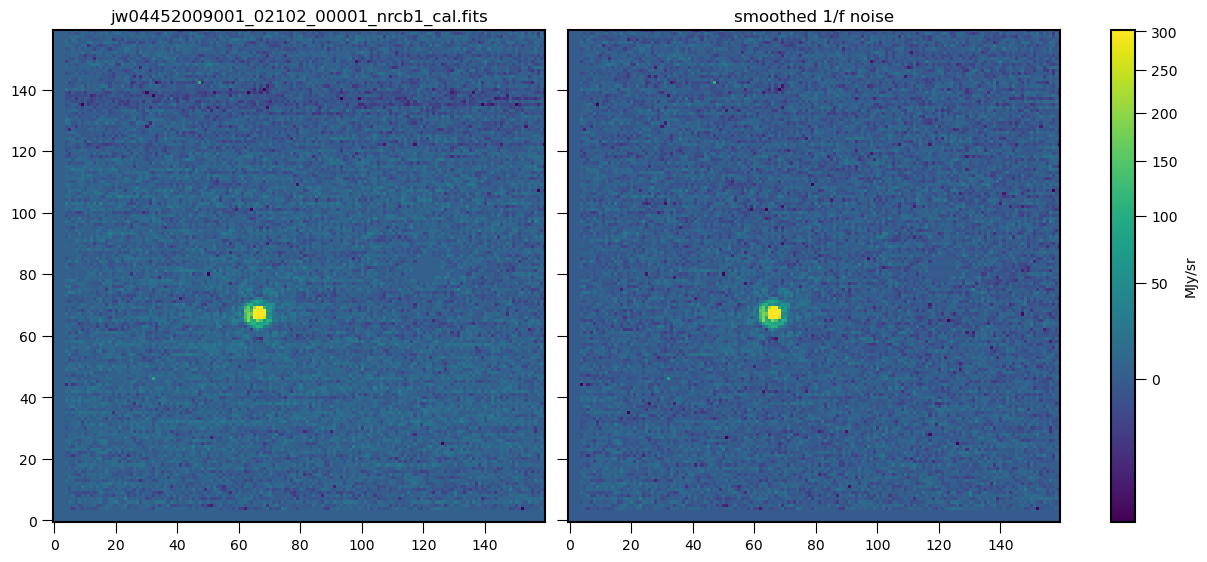

In [44]:
display_images_norm(data, corrected_data, 'smoothed 1/f noise', image_file)

In [50]:
reload(image1overf_subarrays)

<module 'image1overf_subarrays' from '/Users/dcoe/NIRCam/flux/notebooks/image1overf_subarrays.py'>

In [ ]:
for observation in np.arange(1, 46.1):
    infiles = select_jwst_files(allfiles, observation=observation, filetype='cal')
    image_file = infiles[0]
    input_file = os.path.join(datadir, image_file)
    with fits.open(input_file) as cal2hdulist:
        corrected_cal2hdulist = image1overf_subarrays.sub1fimaging(cal2hdulist, sigma_bgmask=3.0, sigma_1fmask=2.0, splitamps=True, usesegmask=True)
        output_file = image_file.replace('_cal.fits','_cal_1overf.fits')
        output_file = os.path.join(output_dir, output_file)
        cal2hdulist.writeto(output_file, overwrite=True)

    data = fits.getdata(input_file)
    corrected_data = fits.getdata(output_file)
    
    print(output_file)
    display_images_norm(data, corrected_data, 'smoothed 1/f noise', image_file)
    output_plot = output_file.replace('.fits', '.png')
    plt.savefig(output_plot)

In [ ]:
# original code that supported two subarrays

def Willott_1overf_correction1(input_file, output_file=None, sigma_bgmask=3.0, sigma_1fmask=2.0, splitamps=True, usesegmask=True):
    with fits.open(input_file) as cal2hdulist:
        # Identify 'nan' values from the Superbias and set those to 0 for plotting
        cal2hdulist['SCI'].data = np.nan_to_num(cal2hdulist['SCI'].data)
        image_data = cal2hdulist['SCI'].data + 0
        
        if cal2hdulist['PRIMARY'].header['SUBARRAY']=='FULL' or cal2hdulist['PRIMARY'].header['SUBARRAY']=='SUB256':
            correcteddata = sub1fimaging(cal2hdulist,sigma_bgmask,sigma_1fmask,splitamps,usesegmask)
            if cal2hdulist['PRIMARY'].header['SUBARRAY']=='FULL':
                cal2hdulist['SCI'].data[4:2044,4:2044] = correcteddata  
            elif cal2hdulist['PRIMARY'].header['SUBARRAY']=='SUB256':
                cal2hdulist['SCI'].data[:252,:252] = correcteddata
            if output_file:
                cal2hdulist.writeto(output_file, overwrite=True)
    
    return cal2hdulist['SCI'].data

# Options:
# sigma_bgmask - sigma of outliers for masking when making background  (suggested value=3.0)
# sigma_1fmask - sigma of outliers for masking when making 1/f correction  (suggested value=2.0)
# splitamps - fit each of the 4 amps separately when full-frame  (set this to True when the field is sparse)
# usesegmask - whether to use a segmentation image as the mask before fitting 1/f stripes (recommend set to True in most cases)